In [8]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import gc
import os
from tqdm import tqdm
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_rows', 600)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [14]:
root_path  = '../data/final_data/'
data_train = pd.read_csv(root_path+'sensor_train_final.csv')
data_test = pd.read_csv(root_path+'sensor_test_final.csv')
sub = pd.read_csv(root_path+'submit_example.csv')
y = data_train.groupby('fragment_id')['behavior_id'].min()
data_test['fragment_id'] += 100000
label = 'behavior_id'
data = pd.concat([data_train, data_test], sort=False,ignore_index=True)
df = data.drop_duplicates(subset=['fragment_id']).reset_index(drop=True)[['fragment_id', 'behavior_id']]
df["count"] = data.groupby("fragment_id")["time_point"].count()

featureList = ["count"]
ans = np.zeros((16000,20))
oof_train = np.zeros((15000,20))

In [15]:
# LGB model
import joblib
# lgboof = joblib.load("LGB_OOF.pkl")
lgboof = joblib.load("LGB.pkl")
# lgboof = joblib.load("LGB_OOF859_____5foldmoremroe.pkl")
oof = lgboof["oof"]
preds = lgboof["test"]
ans += 0.3 * preds
oof_train += 0.3*oof
stack_array = np.concatenate([oof,preds],axis=0)
print(stack_array.shape)
for i in range(20):
    df["lgb_"+str(i)] = stack_array[:,i]
featureList += ["lgb_"+str(i)for i in range(20)]

(31000, 20)


In [16]:
# LSTM model
import joblib 
lstmoof = joblib.load("LSTM.pkl")
oof = lstmoof["oof"]
preds = lstmoof["test"]
ans += 0.3 * preds
oof_train += 0.3*oof
stack_array = np.concatenate([oof,preds],axis=0)
print(stack_array.shape)
for i in range(20):
    df["lstm_"+str(i)] = stack_array[:,i]
featureList += ["lstm_"+str(i)for i in range(20)]

(31000, 20)


In [17]:
# CNN
import joblib 

cnnoof = joblib.load("CNN.pkl")
oof = cnnoof["oof"]
preds = cnnoof["test"]
ans += 0.4 * preds
oof_train += 0.4*oof
stack_array = np.concatenate([oof,preds],axis=0)
print(stack_array.shape)
for i in range(20):
    df["CNN_"+str(i)] = stack_array[:,i]
featureList += ["CNN_"+str(i)for i in range(20)]

# cnnoof = joblib.load("all_stragety_lcy1_0.84695_dict.pkl")
# oof = cnnoof["oof"]
# preds = cnnoof["test"]

# stack_array = np.concatenate([oof,preds],axis=0)
# print(stack_array.shape)
# for i in range(20):
#     df["CNN_"+str(i)] = stack_array[:,i]
# featureList += ["CNN_"+str(i)for i in range(20)]


(31000, 20)


In [24]:
stack_array = np.concatenate([oof_train,ans],axis=0)
print(stack_array.shape)
for i in range(20):
    df["blending"+str(i)] = stack_array[:,i]
featureList += ["blending"+str(i)for i in range(20)]


(31000, 20)


In [22]:
# def acc_combo(y, y_pred):
#     # 数值ID与行为编码的对应关系
#     mapping = {
#         '0': 'A_1', '1': 'B_2', '2': 'A_3', '3': 'A_4', '4': 'B_3', '5': 'C_5', '6': 'C_2', '7': 'A_5', '8': 'B_1', 
#         '9': 'C_1', '10': 'A_2', '11': 'C_3', '12': 'B_5', '13': 'B_4', '14': 'C_4', 
#         '15': 'D_6', '16': 'E_7', '17': 'F_8', '18': 'G_9', '19': 'H_0'
#               }
#     # 将行为ID转为编码
#     code_y, code_y_pred = mapping[str(int(y))], mapping[str(int(y_pred))]
#     if code_y == code_y_pred: #编码完全相同得分1.0
#         return 1.0
#     elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
#         return 1.0/7
#     elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
#         return 1.0/3
#     else:
#         return 0.0

# df = df.fillna(0)
# df.loc[:15000,"istrain"] = 1
# df.loc[15000:,"istrain"] = 0

# train_df = df[df["istrain"]==1].reset_index(drop=True)
# test_df = df[df["istrain"]==0].reset_index(drop=True)
# train_y = train_df[label]
# labels = np.argmax(ans, axis=1)
# oof_y = np.argmax(oof_train, axis=1)
# print(round(accuracy_score(train_y, oof_y), 5))
# score = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
# print(round(score, 5))
# sub = pd.read_csv(root_path+'submit_example.csv')

# sub['behavior_id'] = labels

# vc = data_train['behavior_id'].value_counts().sort_index()
# sns.barplot(vc.index, vc.values)
# plt.show()
# vc = sub['behavior_id'].value_counts().sort_index()
# sns.barplot(vc.index, vc.values)
# plt.show()
# sub.to_csv('blending%.5f.csv' % score, index=False)

0.87327
0.88871


In [25]:
df = df.fillna(0)
df.loc[:15000,"istrain"] = 1
df.loc[15000:,"istrain"] = 0

train_df = df[df["istrain"]==1].reset_index(drop=True)
test_df = df[df["istrain"]==0].reset_index(drop=True)

drop_feat = ["istrain"]
used_feat = [f for f in train_df.columns if f not in (['fragment_id', label] + drop_feat)]
print(len(used_feat))
print(used_feat)

train_x = train_df[used_feat]
train_y = train_df[label]
test_x = test_df[used_feat]
print()

scores = []
imp = pd.DataFrame()
imp['feat'] = used_feat

params = {
    'learning_rate': 0.05,
    'metric': 'multi_error',
    'objective': 'multiclass',
    'num_class': 20,
    'feature_fraction': 0.80,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'n_jobs': 4,
    'seed': 2020,
    'max_depth': 10,
    'num_leaves': 64,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
}

oof_train = np.zeros((len(train_x), 20))
preds = np.zeros((len(test_x), 20))
folds = 5
seeds = [44, 2020, 527, 1527]
for seed in seeds:
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        x_trn, y_trn, x_val, y_val = train_x.iloc[trn_idx], train_y.iloc[trn_idx], train_x.iloc[val_idx], train_y.iloc[val_idx]
        train_set = lgb.Dataset(x_trn, y_trn)
        val_set = lgb.Dataset(x_val, y_val)

        model = lgb.train(params, train_set, num_boost_round=500000,
                          valid_sets=(train_set, val_set), early_stopping_rounds=50,
                          verbose_eval=20)
        oof_train[val_idx] += model.predict(x_val) / len(seeds)
        preds += model.predict(test_x) / folds / len(seeds)
        scores.append(model.best_score['valid_1']['multi_error'])
        imp['gain' + str(fold + 1)] = model.feature_importance(importance_type='gain')
        imp['split' + str(fold + 1)] = model.feature_importance(importance_type='split')
        del x_trn, y_trn, x_val, y_val, model, train_set, val_set
        gc.collect()
imp['gain'] = imp[[f for f in imp.columns if 'gain' in f]].sum(axis=1)/folds
imp['split'] = imp[[f for f in imp.columns if 'split' in f]].sum(axis=1)
imp = imp.sort_values(by=['gain'], ascending=False)
imp[['feat', 'gain', 'split']]
imp = imp.sort_values(by=['split'], ascending=False)
imp[['feat', 'gain', 'split']]

81
['count', 'lgb_0', 'lgb_1', 'lgb_2', 'lgb_3', 'lgb_4', 'lgb_5', 'lgb_6', 'lgb_7', 'lgb_8', 'lgb_9', 'lgb_10', 'lgb_11', 'lgb_12', 'lgb_13', 'lgb_14', 'lgb_15', 'lgb_16', 'lgb_17', 'lgb_18', 'lgb_19', 'lstm_0', 'lstm_1', 'lstm_2', 'lstm_3', 'lstm_4', 'lstm_5', 'lstm_6', 'lstm_7', 'lstm_8', 'lstm_9', 'lstm_10', 'lstm_11', 'lstm_12', 'lstm_13', 'lstm_14', 'lstm_15', 'lstm_16', 'lstm_17', 'lstm_18', 'lstm_19', 'CNN_0', 'CNN_1', 'CNN_2', 'CNN_3', 'CNN_4', 'CNN_5', 'CNN_6', 'CNN_7', 'CNN_8', 'CNN_9', 'CNN_10', 'CNN_11', 'CNN_12', 'CNN_13', 'CNN_14', 'CNN_15', 'CNN_16', 'CNN_17', 'CNN_18', 'CNN_19', 'blending0', 'blending1', 'blending2', 'blending3', 'blending4', 'blending5', 'blending6', 'blending7', 'blending8', 'blending9', 'blending10', 'blending11', 'blending12', 'blending13', 'blending14', 'blending15', 'blending16', 'blending17', 'blending18', 'blending19']

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0779167	valid_1's multi_error: 0.1

6497

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0740833	valid_1's multi_error: 0.120667
[40]	training's multi_error: 0.0570833	valid_1's multi_error: 0.119667
[60]	training's multi_error: 0.03875	valid_1's multi_error: 0.118333
Early stopping, best iteration is:
[15]	training's multi_error: 0.0791667	valid_1's multi_error: 0.118333


316

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0738333	valid_1's multi_error: 0.115667
[40]	training's multi_error: 0.0561667	valid_1's multi_error: 0.116667
[60]	training's multi_error: 0.0391667	valid_1's multi_error: 0.117
Early stopping, best iteration is:
[29]	training's multi_error: 0.0669167	valid_1's multi_error: 0.114


6280

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0739167	valid_1's multi_error: 0.129667
[40]	training's multi_error: 0.0549167	valid_1's multi_error: 0.130333
[60]	training's multi_error: 0.0370833	valid_1's multi_error: 0.128667
Early stopping, best iteration is:
[14]	training's multi_error: 0.08025	valid_1's multi_error: 0.126333


312

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0738333	valid_1's multi_error: 0.123667
[40]	training's multi_error: 0.0559167	valid_1's multi_error: 0.122
[60]	training's multi_error: 0.0376667	valid_1's multi_error: 0.121667
[80]	training's multi_error: 0.0221667	valid_1's multi_error: 0.122667
[100]	training's multi_error: 0.0106667	valid_1's multi_error: 0.123333
Early stopping, best iteration is:
[58]	training's multi_error: 0.0386667	valid_1's multi_error: 0.120333


12

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0729167	valid_1's multi_error: 0.116667
[40]	training's multi_error: 0.0551667	valid_1's multi_error: 0.115667
[60]	training's multi_error: 0.0375833	valid_1's multi_error: 0.115667
Early stopping, best iteration is:
[27]	training's multi_error: 0.06625	valid_1's multi_error: 0.114333


373

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0735	valid_1's multi_error: 0.122
[40]	training's multi_error: 0.0555	valid_1's multi_error: 0.123
[60]	training's multi_error: 0.039	valid_1's multi_error: 0.121
[80]	training's multi_error: 0.0224167	valid_1's multi_error: 0.12
[100]	training's multi_error: 0.01175	valid_1's multi_error: 0.122333
[120]	training's multi_error: 0.00541667	valid_1's multi_error: 0.122
Early stopping, best iteration is:
[80]	training's multi_error: 0.0224167	valid_1's multi_error: 0.12


64

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0746667	valid_1's multi_error: 0.111333
[40]	training's multi_error: 0.0573333	valid_1's multi_error: 0.108667
[60]	training's multi_error: 0.03925	valid_1's multi_error: 0.111
[80]	training's multi_error: 0.0229167	valid_1's multi_error: 0.111333
Early stopping, best iteration is:
[36]	training's multi_error: 0.0615	valid_1's multi_error: 0.108


409

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0764167	valid_1's multi_error: 0.119333
[40]	training's multi_error: 0.0585833	valid_1's multi_error: 0.12
[60]	training's multi_error: 0.0391667	valid_1's multi_error: 0.121333
[80]	training's multi_error: 0.0220833	valid_1's multi_error: 0.118333
[100]	training's multi_error: 0.011	valid_1's multi_error: 0.117667
[120]	training's multi_error: 0.0045	valid_1's multi_error: 0.117
[140]	training's multi_error: 0.00191667	valid_1's multi_error: 0.117
Early stopping, best iteration is:
[109]	training's multi_error: 0.007	valid_1's multi_error: 0.116333


152

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0755	valid_1's multi_error: 0.123667
[40]	training's multi_error: 0.0576667	valid_1's multi_error: 0.122
[60]	training's multi_error: 0.04	valid_1's multi_error: 0.121667
Early stopping, best iteration is:
[28]	training's multi_error: 0.0668333	valid_1's multi_error: 0.121333


377

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.07375	valid_1's multi_error: 0.119
[40]	training's multi_error: 0.05475	valid_1's multi_error: 0.12
[60]	training's multi_error: 0.0375	valid_1's multi_error: 0.119667
Early stopping, best iteration is:
[23]	training's multi_error: 0.0719167	valid_1's multi_error: 0.117


348

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0769167	valid_1's multi_error: 0.121333
[40]	training's multi_error: 0.05775	valid_1's multi_error: 0.119333
[60]	training's multi_error: 0.0394167	valid_1's multi_error: 0.118667
Early stopping, best iteration is:
[25]	training's multi_error: 0.0725	valid_1's multi_error: 0.118


356

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0745	valid_1's multi_error: 0.120667
[40]	training's multi_error: 0.0550833	valid_1's multi_error: 0.122
[60]	training's multi_error: 0.0373333	valid_1's multi_error: 0.121667
Early stopping, best iteration is:
[25]	training's multi_error: 0.0685	valid_1's multi_error: 0.118


356

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0745	valid_1's multi_error: 0.113333
[40]	training's multi_error: 0.0566667	valid_1's multi_error: 0.111667
[60]	training's multi_error: 0.0398333	valid_1's multi_error: 0.111667
Early stopping, best iteration is:
[16]	training's multi_error: 0.0786667	valid_1's multi_error: 0.110667


320

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0754167	valid_1's multi_error: 0.121
[40]	training's multi_error: 0.0581667	valid_1's multi_error: 0.119
[60]	training's multi_error: 0.0389167	valid_1's multi_error: 0.122
[80]	training's multi_error: 0.02375	valid_1's multi_error: 0.121667
Early stopping, best iteration is:
[38]	training's multi_error: 0.05925	valid_1's multi_error: 0.118333


417

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.07625	valid_1's multi_error: 0.108
[40]	training's multi_error: 0.0575833	valid_1's multi_error: 0.108333
[60]	training's multi_error: 0.0388333	valid_1's multi_error: 0.112
Early stopping, best iteration is:
[18]	training's multi_error: 0.0785	valid_1's multi_error: 0.108


328

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0725	valid_1's multi_error: 0.119
[40]	training's multi_error: 0.0556667	valid_1's multi_error: 0.118333
[60]	training's multi_error: 0.0375	valid_1's multi_error: 0.115667
[80]	training's multi_error: 0.0223333	valid_1's multi_error: 0.116333
[100]	training's multi_error: 0.0110833	valid_1's multi_error: 0.115
[120]	training's multi_error: 0.00583333	valid_1's multi_error: 0.115333
[140]	training's multi_error: 0.00308333	valid_1's multi_error: 0.115667
Early stopping, best iteration is:
[99]	training's multi_error: 0.0114167	valid_1's multi_error: 0.114333


140

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0765	valid_1's multi_error: 0.116333
[40]	training's multi_error: 0.0595	valid_1's multi_error: 0.116
[60]	training's multi_error: 0.03725	valid_1's multi_error: 0.116667
[80]	training's multi_error: 0.02225	valid_1's multi_error: 0.117
Early stopping, best iteration is:
[31]	training's multi_error: 0.0679167	valid_1's multi_error: 0.114


389

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.075	valid_1's multi_error: 0.116333
[40]	training's multi_error: 0.0588333	valid_1's multi_error: 0.119
[60]	training's multi_error: 0.0400833	valid_1's multi_error: 0.119
Early stopping, best iteration is:
[16]	training's multi_error: 0.079	valid_1's multi_error: 0.116


320

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0739167	valid_1's multi_error: 0.127333
[40]	training's multi_error: 0.0548333	valid_1's multi_error: 0.125333
[60]	training's multi_error: 0.0366667	valid_1's multi_error: 0.122667
[80]	training's multi_error: 0.0219167	valid_1's multi_error: 0.123
[100]	training's multi_error: 0.0106667	valid_1's multi_error: 0.124333
[120]	training's multi_error: 0.00483333	valid_1's multi_error: 0.124
Early stopping, best iteration is:
[72]	training's multi_error: 0.0275	valid_1's multi_error: 0.121333


32

feat          gain  split
68   blending7  28273.005058   1509
73  blending12  24143.943029   1557
66   blending5  19428.985518   1476
17      lgb_16  18981.496178   1375
65   blending4  17040.529183   1374
74  blending13  16272.038655   1389
69   blending8  16044.367018   1176
16      lgb_15  14648.533917   1804
61   blending0  13381.875522   1104
62   blending1  13204.624393   1120
63   blending2  12896.258545   1236
64   blending3  12669.306413   1313
20      lgb_19  12461.450269    668
72  blending11  11983.913839   1266
60      CNN_19  11821.307732    753
79  blending18  10937.721633   1252
70   blending9  10644.718929   1317
40     lstm_19  10546.239578    837
78  blending17   9706.331927   1228
19      lgb_18   8582.590031   1301
75  blending14   8493.676337   1479
67   blending6   7772.991043   1071
55      CNN_14   6333.025368   1514
18      lgb_17   6058.865138   1149
50       CNN_9   5429.880059   1318
71  blending10   5359.608024   1249
76  blending15   5312.934909   1432
52      CNN_11   5092.180342   1446
41       CNN_0   5038.219603   1172
1        lgb_0   4825.467844   1077
2        lgb_1   4748.627054   1268
7        lgb_6   4533.379959   1166
9        lgb_8   4069.166842   1143
46       CNN_5   4045.370499   1452
11      lgb_10   3184.765182   1389
14      lgb_13   3023.863138   1486
80  blending19   2943.466024    650
44       CNN_3   2937.960407   1217
15      lgb_14   2902.215732   1453
3        lgb_2   2866.348230   1281
13      lgb_12   2684.315390   1531
45       CNN_4   2512.226417   1188
77  blending16   2229.744738   1210
59      CNN_18   2193.477113   1268
29      lstm_8   2036.308392   1205
4        lgb_3   1649.345126   1278
43       CNN_2   1581.784439   1402
48       CNN_7   1539.512574   1303
56      CNN_15   1526.054754   1419
25      lstm_4   1501.408162   1133
53      CNN_12   1456.590056   1684
6        lgb_5   1446.517470   1270
39     lstm_18   1393.284383   1305
5        lgb_4   1374.159322   1118
51      CNN_10   1339.975218   1111
35     lstm_14   1196.261235   1346
10       lgb_9   1131.219042   1330
34     lstm_13   1121.496653   1237
57      CNN_16   1108.654562   1167
12      lgb_11   1090.914523   1186
30      lstm_9   1003.018453   1577
38     lstm_17    923.687112   1374
54      CNN_13    878.253999   1166
42       CNN_1    846.030428   1167
58      CNN_17    840.311867   1294
47       CNN_6    834.429966   1290
21      lstm_0    794.330447   1236
8        lgb_7    745.605404   1176
36     lstm_15    689.799076   1373
24      lstm_3    613.994142   1241
27      lstm_6    538.812164   1281
33     lstm_12    537.862676   1334
23      lstm_2    517.509781   1518
26      lstm_5    494.169247   1491
22      lstm_1    490.285638   1308
49       CNN_8    478.098285   1217
32     lstm_11    472.943580   1281
31     lstm_10    452.075392   1419
37     lstm_16    433.897888   1085
28      lstm_7    346.377650   1110
0        count    243.876566    815

feat          gain  split
16      lgb_15  14648.533917   1804
53      CNN_12   1456.590056   1684
30      lstm_9   1003.018453   1577
73  blending12  24143.943029   1557
13      lgb_12   2684.315390   1531
23      lstm_2    517.509781   1518
55      CNN_14   6333.025368   1514
68   blending7  28273.005058   1509
26      lstm_5    494.169247   1491
14      lgb_13   3023.863138   1486
75  blending14   8493.676337   1479
66   blending5  19428.985518   1476
15      lgb_14   2902.215732   1453
46       CNN_5   4045.370499   1452
52      CNN_11   5092.180342   1446
76  blending15   5312.934909   1432
31     lstm_10    452.075392   1419
56      CNN_15   1526.054754   1419
43       CNN_2   1581.784439   1402
11      lgb_10   3184.765182   1389
74  blending13  16272.038655   1389
17      lgb_16  18981.496178   1375
65   blending4  17040.529183   1374
38     lstm_17    923.687112   1374
36     lstm_15    689.799076   1373
35     lstm_14   1196.261235   1346
33     lstm_12    537.862676   1334
10       lgb_9   1131.219042   1330
50       CNN_9   5429.880059   1318
70   blending9  10644.718929   1317
64   blending3  12669.306413   1313
22      lstm_1    490.285638   1308
39     lstm_18   1393.284383   1305
48       CNN_7   1539.512574   1303
19      lgb_18   8582.590031   1301
58      CNN_17    840.311867   1294
47       CNN_6    834.429966   1290
32     lstm_11    472.943580   1281
27      lstm_6    538.812164   1281
3        lgb_2   2866.348230   1281
4        lgb_3   1649.345126   1278
6        lgb_5   1446.517470   1270
2        lgb_1   4748.627054   1268
59      CNN_18   2193.477113   1268
72  blending11  11983.913839   1266
79  blending18  10937.721633   1252
71  blending10   5359.608024   1249
24      lstm_3    613.994142   1241
34     lstm_13   1121.496653   1237
63   blending2  12896.258545   1236
21      lstm_0    794.330447   1236
78  blending17   9706.331927   1228
49       CNN_8    478.098285   1217
44       CNN_3   2937.960407   1217
77  blending16   2229.744738   1210
29      lstm_8   2036.308392   1205
45       CNN_4   2512.226417   1188
12      lgb_11   1090.914523   1186
69   blending8  16044.367018   1176
8        lgb_7    745.605404   1176
41       CNN_0   5038.219603   1172
57      CNN_16   1108.654562   1167
42       CNN_1    846.030428   1167
54      CNN_13    878.253999   1166
7        lgb_6   4533.379959   1166
18      lgb_17   6058.865138   1149
9        lgb_8   4069.166842   1143
25      lstm_4   1501.408162   1133
62   blending1  13204.624393   1120
5        lgb_4   1374.159322   1118
51      CNN_10   1339.975218   1111
28      lstm_7    346.377650   1110
61   blending0  13381.875522   1104
37     lstm_16    433.897888   1085
1        lgb_0   4825.467844   1077
67   blending6   7772.991043   1071
40     lstm_19  10546.239578    837
0        count    243.876566    815
60      CNN_19  11821.307732    753
20      lgb_19  12461.450269    668
80  blending19   2943.466024    650

0.88333
0.89898


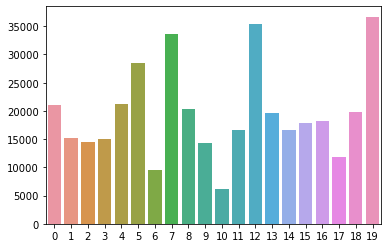

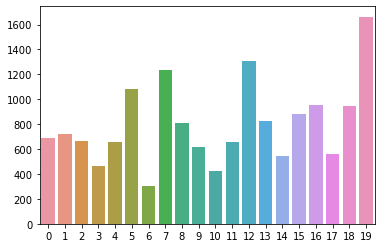

In [26]:
def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {
        '0': 'A_1', '1': 'B_2', '2': 'A_3', '3': 'A_4', '4': 'B_3', '5': 'C_5', '6': 'C_2', '7': 'A_5', '8': 'B_1', 
        '9': 'C_1', '10': 'A_2', '11': 'C_3', '12': 'B_5', '13': 'B_4', '14': 'C_4', 
        '15': 'D_6', '16': 'E_7', '17': 'F_8', '18': 'G_9', '19': 'H_0'
              }
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[str(int(y))], mapping[str(int(y_pred))]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0
labels = np.argmax(preds, axis=1)
oof_y = np.argmax(oof_train, axis=1)
print(round(accuracy_score(train_y, oof_y), 5))
score = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(score, 5))

sub = pd.read_csv(root_path+'submit_example.csv')

sub['behavior_id'] = labels

vc = data_train['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
sub.to_csv('emsemble%.5f.csv' % score, index=False)